In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import  MultiLabelBinarizer
from textblob import Word, TextBlob
from nltk.corpus import stopwords
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 500)
pd.options.display.max_colwidth = 100
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('RAW_recipes.csv')

In [3]:
random_foods = pd.Series(df['id']).sample(20000, random_state=17).values.tolist()
df = df[df['id'].isin(random_foods)].reset_index(drop=True)

In [4]:
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,chile rellenos,43026,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'n...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on sheet pan', 'open up chile and place on egg roll ...",a favorite from a local restaurant no longer in business. not an authentic mexican chile relleno...,"['egg roll wrap', 'whole green chilies', 'cheese', 'cornstarch', 'oil']",5
1,global gourmet taco casserole,59952,55,28604,2003-04-16,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...","[456.8, 40.0, 34.0, 67.0, 57.0, 51.0, 9.0]",11,"['heat oven to 375 degrees', 'brown ground beef and onion over medium heat', 'drain', 'stir in t...",hey! i found this in a cookbook that recognizes different kinds of food from around the world. m...,"['ground beef', 'onion', 'tomato sauce', 'taco sauce', 'salt', 'pepper', 'tabasco sauce', 'hot c...",12
2,i can t believe it s spinach,38798,30,1533,2002-08-29,"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'appetizers',...","[53.8, 5.0, 2.0, 3.0, 3.0, 3.0, 1.0]",5,"['combine all ingredients in a large bowl and mix well', 'shape into one-inch balls', 'cover and...","these were so go, it surprised even me.","['frozen chopped spinach', 'eggs', 'garlic powder', 'soft breadcrumbs', 'oregano', 'margarine', ...",8
3,i don t feel like cooking tonight casserole,22123,45,34687,2002-03-11,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', '...","[647.6, 57.0, 57.0, 58.0, 54.0, 53.0, 16.0]",6,"['brown onion and meat in the oil , drain any excess moisture', 'remove from heat and add both c...",this is a hearty and filling casserole for those nights when a long time in the kitchen is just ...,"['ground beef', 'onion', 'frozen vegetables', 'cream of mushroom soup', 'condensed cream of mush...",8
4,jeanne s style birthday cake,83025,230,116315,2004-02-04,"['time-to-make', 'course', 'preparation', 'occasion', 'desserts', 'oven', 'dinner-party', 'cakes...","[5467.4, 516.0, 1196.0, 135.0, 110.0, 615.0, 188.0]",25,"['to prepare base , cut shortening into dry ingredients , mix well', 'pat firmly and evenly into...",a bakery in winnipeg is famous for this special cake and ship it to all parts of canada. a recip...,"['shortening', 'icing sugar', 'vanilla', 'all-purpose flour', 'baking powder', 'sugar', 'eggs', ...",10


In [5]:
df.isnull().sum()

name                0
id                  0
minutes             0
contributor_id      0
submitted           0
tags                0
nutrition           0
n_steps             0
steps               0
description       425
ingredients         0
n_ingredients       0
dtype: int64

In [6]:
df['ingredients'] = df['ingredients'].str.replace('[', '')
df['ingredients'] = df['ingredients'].str.replace(']', '')
df['ingredients'] = df['ingredients'].str.replace("'", '') 
df['tags'] = df['tags'].str.replace('[', '')
df['tags'] = df['tags'].str.replace(']', '')
df['tags'] = df['tags'].str.replace("'", '') 

In [7]:
one_hot_tag = MultiLabelBinarizer()
y_classes_tag = one_hot_tag.fit_transform(df['tags'].str.split(', '))

In [8]:
one_hot_tag.classes_[:20]

array(['', '1-day-or-more', '15-minutes-or-less', '3-steps-or-less',
       '30-minutes-or-less', '4-hours-or-less', '5-ingredients-or-less',
       '60-minutes-or-less', 'a1-sauce', 'african', 'american',
       'amish-mennonite', 'angolan', 'appetizers', 'apples', 'argentine',
       'artichoke', 'asian', 'asparagus', 'australian'], dtype=object)

In [9]:
y_classes_tag = pd.DataFrame(y_classes_tag,columns=one_hot_tag.classes_)
avg_tag = y_classes_tag.mean().sort_values(ascending=False)

In [10]:
avg_tag[:20]

preparation          1.00
time-to-make         0.98
course               0.94
main-ingredient      0.73
dietary              0.71
easy                 0.54
occasion             0.49
cuisine              0.39
low-in-something     0.37
main-dish            0.31
equipment            0.31
60-minutes-or-less   0.30
number-of-servings   0.25
meat                 0.25
vegetables           0.24
30-minutes-or-less   0.23
taste-mood           0.22
4-hours-or-less      0.22
north-american       0.21
3-steps-or-less      0.19
dtype: float64

**Tags can provide clues for clustering as they contain information about the recipe.**

In [11]:
tags = avg_tag[(avg_tag>0.1) & (avg_tag<0.9)].index.tolist()
tag_df = y_classes_tag[tags]

In [12]:
tag_df.head()

,main-ingredient,dietary,easy,occasion,cuisine,low-in-something,main-dish,equipment,60-minutes-or-less,number-of-servings,meat,vegetables,30-minutes-or-less,taste-mood,4-hours-or-less,north-american,3-steps-or-less,15-minutes-or-less,low-sodium,low-carb,desserts,healthy,dinner-party,low-cholesterol,low-calorie,beginner-cook,vegetarian,5-ingredients-or-less,holiday-event,inexpensive,low-protein,low-saturated-fat,oven,american,fruit,eggs-dairy,side-dishes,kid-friendly,healthy-2,pasta-rice-and-grains,comfort-food,presentation,lunch,poultry,european
0,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,1,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
4,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
not_low =[col for col in tag_df.columns if 'low' not in col]

In [14]:
tag_df = tag_df[not_low]

In [15]:
one_hot_ing = MultiLabelBinarizer()
y_classes_ing = one_hot_ing.fit_transform(df['ingredients'].str.split(', '))

In [16]:
one_hot_ing.classes_[:20]

array(['"adolphs meat tenderizer"', '"bakers semi-sweet chocolate"',
       '"bells seasoning"', '"breakstones sour cream"',
       '"campbells cheddar cheese soup"',
       '"campbells chicken gumbo soup"',
       '"campbells condensed cream of celery soup"',
       '"campbells cream of chicken soup"',
       '"campbells cream of mushroom soup"',
       '"campbells cream of shrimp soup"',
       '"campbells creamy ranchero tomato soup"',
       '"campbells french onion soup"', '"chicken a la king"',
       '"colemans dry mustard"', '"confectioners sugar"',
       '"dales steak seasoning"', '"devils food cake mix"',
       '"durkees sauce"', '"emerils original essence"',
       '"europes best romanesco concerto frozen vegetables"'],
      dtype=object)

In [17]:
y_classes_ing = pd.DataFrame(y_classes_ing, columns=one_hot_ing.classes_)
avg_ing = y_classes_ing.mean().sort_values(ascending=False)

In [18]:
avg_ing[:20]

salt                0.37
butter              0.23
sugar               0.19
onion               0.17
water               0.15
olive oil           0.14
eggs                0.14
garlic cloves       0.11
flour               0.11
milk                0.11
pepper              0.10
brown sugar         0.08
garlic              0.08
all-purpose flour   0.07
baking powder       0.07
egg                 0.07
salt and pepper     0.07
parmesan cheese     0.06
lemon juice         0.06
vegetable oil       0.06
dtype: float64

In [19]:
ing = avg_ing[avg_ing>=0.01].index.tolist()
ing_df = y_classes_ing[ing]

**The ingredients contains significant information about which cluster the foods belong to.**

In [20]:
ing_df.head()

,salt,butter,sugar,onion,water,olive oil,eggs,garlic cloves,flour,milk,pepper,brown sugar,garlic,all-purpose flour,baking powder,egg,salt and pepper,parmesan cheese,lemon juice,vegetable oil,baking soda,black pepper,vanilla,tomatoes,cinnamon,sour cream,garlic powder,cream cheese,onions,vanilla extract,oil,honey,celery,garlic clove,soy sauce,cheddar cheese,mayonnaise,unsalted butter,worcestershire sauce,chicken broth,paprika,extra virgin olive oil,cornstarch,fresh parsley,carrots,bacon,fresh ground black pepper,parsley,chili powder,ground cumin,potatoes,lemon,carrot,ground cinnamon,cayenne pepper,nutmeg,ground beef,granulated sugar,red onion,green onion,green onions,walnuts,pecans,dijon mustard,heavy cream,mozzarella cheese,kosher salt,margarine,powdered sugar,fresh lemon juice,dried oregano,fresh cilantro,tomato paste,zucchini,red bell pepper,orange juice,oregano,tomato sauce,chicken stock,ketchup,raisins,green pepper,canola oil,cumin,ginger,lime juice,boneless skinless chicken breasts,fresh ginger,cilantro,balsamic vinegar,onion powder,juice of,dried thyme,buttermilk,ground black pepper,red wine vinegar,ground ginger,fresh basil,vinegar,diced tomatoes,dry white wine,bay leaf,green bell pepper,sea salt,dried basil,white sugar,thyme,egg whites,crushed red pepper flakes,sesame oil,curry powder,"""confectioners sugar""",white pepper,fresh ground pepper,whole wheat flour,salt & freshly ground black pepper,garlic salt,dry mustard,light brown sugar,basil,cider vinegar,red pepper flakes,ground nutmeg,boiling water,shortening,mushrooms,sharp cheddar cheese,whipping cream,breadcrumbs,chicken breasts,salsa,cheese,monterey jack cheese,feta cheese,semi-sweet chocolate chips,bananas,bay leaves,white wine,banana,egg yolks,chocolate chips,lean ground beef,cooking spray,peanut butter,nuts,beef broth,scallions,half-and-half,sesame seeds
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
ing_df.drop(['eggs', 'onions', 'bananas', 'ginger'], axis=1, inplace=True)

In [22]:
df = pd.concat([ing_df, df], axis=1)

In [23]:
df = pd.concat([tag_df, df], axis=1)

In [24]:
df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)',
    'saturated fat (PDV)', 'carbohydrates (PDV)']] = df.nutrition.str.split(",", expand=True)

df['calories'] = df['calories'].str.replace('[', '')
df['carbohydrates (PDV)'] = df['carbohydrates (PDV)'].str.replace(']', '')
df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)',
    'carbohydrates (PDV)']] = df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
                                  'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']].astype('float')

In [25]:
df.drop(['tags', 'nutrition', 'steps'], axis=1, inplace=True)

In [26]:
df.shape

(20000, 199)

### Outliers

In [27]:
df.loc[:, 'minutes':].describe([.05, .1, .25, .75, .9, .95, .99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
minutes,20000.00,124.54,2171.67,0.00,5.00,10.00,20.00,40.00,65.00,135.00,255.00,900.10,259260.00
contributor_id,20000.00,4816303.11,92909897.75,1530.00,10404.00,26399.00,57042.00,174096.00,400708.00,780172.00,1127964.25,2032594.00,2002285039.00
n_steps,20000.00,9.80,5.99,1.00,3.00,4.00,6.00,9.00,12.00,17.00,21.00,30.00,97.00
n_ingredients,20000.00,9.06,3.77,1.00,4.00,5.00,6.00,9.00,11.00,14.00,16.00,20.00,43.00
calories,20000.00,471.46,744.55,0.00,59.00,91.40,172.80,310.20,517.10,843.54,1293.51,3615.54,38662.30
total fat (PDV),20000.00,36.34,72.33,0.00,0.00,2.00,8.00,20.00,41.00,74.00,113.00,301.02,4331.00
sugar (PDV),20000.00,79.80,228.92,0.00,1.00,3.00,9.00,24.00,66.00,157.00,269.00,1074.02,6098.00
sodium (PDV),20000.00,30.66,117.27,0.00,0.00,1.00,5.00,15.00,33.00,62.00,92.00,224.01,9692.00
protein (PDV),20000.00,35.29,72.90,0.00,1.00,2.00,7.00,18.00,50.00,83.00,109.00,191.00,6552.00
saturated fat (PDV),20000.00,45.66,94.34,0.00,0.00,1.00,7.00,22.00,53.00,98.00,147.00,419.00,4969.00


In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=q1, q3=q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [29]:
cols_threshold = [col for col in df.loc[:, 'minutes':'carbohydrates (PDV)'].\
                  columns if col not in ['contributor_id', 'submitted', 'ingredients', 'description']]

In [30]:
for col in cols_threshold:
    if col in ['n_steps', 'n_ingredients']:
        replace_with_thresholds(df, col, q1=.05, q3=.95)
    else:
        replace_with_thresholds(df, col)

In [31]:
df.loc[:, 'minutes':].describe([.05, .1, .25, .75, .9, .95, .99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
minutes,20000.00,79.29,190.17,0.00,5.00,10.00,20.00,40.00,65.00,135.00,255.00,900.10,2247.25
contributor_id,20000.00,4816303.11,92909897.75,1530.00,10404.00,26399.00,57042.00,174096.00,400708.00,780172.00,1127964.25,2032594.00,2002285039.00
n_steps,20000.00,9.79,5.90,1.00,3.00,4.00,6.00,9.00,12.00,17.00,21.00,30.00,48.00
n_ingredients,20000.00,9.06,3.76,1.00,4.00,5.00,6.00,9.00,11.00,14.00,16.00,20.00,34.00
calories,20000.00,468.47,673.74,0.00,59.00,91.40,172.80,310.20,517.10,843.54,1293.51,3615.54,9016.06
total fat (PDV),20000.00,35.85,60.15,0.00,0.00,2.00,8.00,20.00,41.00,74.00,113.00,301.02,752.55
sugar (PDV),20000.00,78.66,210.95,0.00,1.00,3.00,9.00,24.00,66.00,157.00,269.00,1074.02,2685.05
sodium (PDV),20000.00,28.04,48.12,0.00,0.00,1.00,5.00,15.00,33.00,62.00,92.00,224.01,560.02
protein (PDV),20000.00,34.40,43.85,0.00,1.00,2.00,7.00,18.00,50.00,83.00,109.00,191.00,477.50
saturated fat (PDV),20000.00,45.18,83.50,0.00,0.00,1.00,7.00,22.00,53.00,98.00,147.00,419.00,1047.50


In [32]:
(df.isnull().sum() * 100 / df.shape[0]).sort_values(ascending=False)[:5]

description         2.12
main-ingredient     0.00
green bell pepper   0.00
dried thyme         0.00
buttermilk          0.00
dtype: float64

In [33]:
df.dropna(inplace=True)

In [34]:
df.drop(['contributor_id', 'id'], axis=1, inplace=True)

In [35]:
df_ = df.loc[:, 'name':].copy()

In [36]:
drop_cols = ['ingredients', 'description', 'name']
df.drop(drop_cols, axis=1, inplace=True)

**Since the food habits of the masses may change according to the years and months, we add this informations as new columns.**

In [37]:
df['submitted'] = pd.to_datetime(df['submitted'])
df['year'] = df.submitted.dt.year
df['month'] = df.submitted.dt.month
df.drop('submitted', axis=1, inplace=True)

In [38]:
df = pd.get_dummies(df, columns=['year', 'month'],
                    drop_first=True)

In [39]:
df.head()

,main-ingredient,dietary,easy,occasion,cuisine,main-dish,equipment,60-minutes-or-less,number-of-servings,meat,vegetables,30-minutes-or-less,taste-mood,4-hours-or-less,north-american,3-steps-or-less,15-minutes-or-less,desserts,healthy,dinner-party,beginner-cook,vegetarian,5-ingredients-or-less,holiday-event,inexpensive,oven,american,fruit,eggs-dairy,side-dishes,kid-friendly,healthy-2,pasta-rice-and-grains,comfort-food,presentation,lunch,poultry,european,salt,butter,sugar,onion,water,olive oil,garlic cloves,flour,milk,pepper,brown sugar,garlic,all-purpose flour,baking powder,egg,salt and pepper,parmesan cheese,lemon juice,vegetable oil,baking soda,black pepper,vanilla,tomatoes,cinnamon,sour cream,garlic powder,cream cheese,vanilla extract,oil,honey,celery,garlic clove,soy sauce,cheddar cheese,mayonnaise,unsalted butter,worcestershire sauce,chicken broth,paprika,extra virgin olive oil,cornstarch,fresh parsley,carrots,bacon,fresh ground black pepper,parsley,chili powder,ground cumin,potatoes,lemon,carrot,ground cinnamon,cayenne pepper,nutmeg,ground beef,granulated sugar,red onion,green onion,green onions,walnuts,pecans,dijon mustard,heavy cream,mozzarella cheese,kosher salt,margarine,powdered sugar,fresh lemon juice,dried oregano,fresh cilantro,tomato paste,zucchini,red bell pepper,orange juice,oregano,tomato sauce,chicken stock,ketchup,raisins,green pepper,canola oil,cumin,lime juice,boneless skinless chicken breasts,fresh ginger,cilantro,balsamic vinegar,onion powder,juice of,dried thyme,buttermilk,ground black pepper,red wine vinegar,ground ginger,fresh basil,vinegar,diced tomatoes,dry white wine,bay leaf,green bell pepper,sea salt,dried basil,white sugar,thyme,egg whites,crushed red pepper flakes,sesame oil,curry powder,"""confectioners sugar""",white pepper,fresh ground pepper,whole wheat flour,salt & freshly ground black pepper,garlic salt,dry mustard,light brown sugar,basil,cider vinegar,red pepper flakes,ground nutmeg,boiling water,shortening,mushrooms,sharp cheddar cheese,whipping cream,breadcrumbs,chicken breasts,salsa,cheese,monterey jack cheese,feta cheese,semi-sweet chocolate chips,bay leaves,white wine,banana,egg yolks,chocolate chips,lean ground beef,cooking spray,peanut butter,nuts,beef broth,scallions,half-and-half,sesame seeds,minutes,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45.00,9,5,94.00,10.00,0.00,11.00,11.00,21.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55.00,11,12,456.80,40.00,34.00,67.00,57.00,51.00,9.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [40]:
scaler_cols = df.loc[:, 'minutes':'carbohydrates (PDV)'].columns.tolist()

In [41]:
sc = MinMaxScaler((0, 1))
df[scaler_cols] = sc.fit_transform(df[scaler_cols])

In [42]:
df.head()

,main-ingredient,dietary,easy,occasion,cuisine,main-dish,equipment,60-minutes-or-less,number-of-servings,meat,vegetables,30-minutes-or-less,taste-mood,4-hours-or-less,north-american,3-steps-or-less,15-minutes-or-less,desserts,healthy,dinner-party,beginner-cook,vegetarian,5-ingredients-or-less,holiday-event,inexpensive,oven,american,fruit,eggs-dairy,side-dishes,kid-friendly,healthy-2,pasta-rice-and-grains,comfort-food,presentation,lunch,poultry,european,salt,butter,sugar,onion,water,olive oil,garlic cloves,flour,milk,pepper,brown sugar,garlic,all-purpose flour,baking powder,egg,salt and pepper,parmesan cheese,lemon juice,vegetable oil,baking soda,black pepper,vanilla,tomatoes,cinnamon,sour cream,garlic powder,cream cheese,vanilla extract,oil,honey,celery,garlic clove,soy sauce,cheddar cheese,mayonnaise,unsalted butter,worcestershire sauce,chicken broth,paprika,extra virgin olive oil,cornstarch,fresh parsley,carrots,bacon,fresh ground black pepper,parsley,chili powder,ground cumin,potatoes,lemon,carrot,ground cinnamon,cayenne pepper,nutmeg,ground beef,granulated sugar,red onion,green onion,green onions,walnuts,pecans,dijon mustard,heavy cream,mozzarella cheese,kosher salt,margarine,powdered sugar,fresh lemon juice,dried oregano,fresh cilantro,tomato paste,zucchini,red bell pepper,orange juice,oregano,tomato sauce,chicken stock,ketchup,raisins,green pepper,canola oil,cumin,lime juice,boneless skinless chicken breasts,fresh ginger,cilantro,balsamic vinegar,onion powder,juice of,dried thyme,buttermilk,ground black pepper,red wine vinegar,ground ginger,fresh basil,vinegar,diced tomatoes,dry white wine,bay leaf,green bell pepper,sea salt,dried basil,white sugar,thyme,egg whites,crushed red pepper flakes,sesame oil,curry powder,"""confectioners sugar""",white pepper,fresh ground pepper,whole wheat flour,salt & freshly ground black pepper,garlic salt,dry mustard,light brown sugar,basil,cider vinegar,red pepper flakes,ground nutmeg,boiling water,shortening,mushrooms,sharp cheddar cheese,whipping cream,breadcrumbs,chicken breasts,salsa,cheese,monterey jack cheese,feta cheese,semi-sweet chocolate chips,bay leaves,white wine,banana,egg yolks,chocolate chips,lean ground beef,cooking spray,peanut butter,nuts,beef broth,scallions,half-and-half,sesame seeds,minutes,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.17,0.12,0.01,0.01,0.00,0.02,0.02,0.02,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.21,0.33,0.05,0.05,0.01,0.12,0.12,0.05,0.02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [43]:
df.shape

(19575, 223)

In [44]:
kmeans = KMeans(n_clusters=8, random_state=17).fit(df)
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 8,
 'n_init': 10,
 'random_state': 17,
 'tol': 0.0001,
 'verbose': 0}

In [45]:
kmeans.labels_

array([4, 2, 3, ..., 5, 0, 7], dtype=int32)

In [46]:
kmeans.inertia_

207675.3714253616

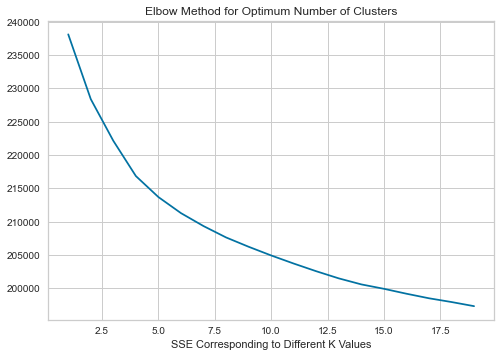

In [47]:
kmeans = KMeans()
ssd = []
K = range(1, 20)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df)
    ssd.append(kmeans.inertia_)
    
plt.plot(K, ssd, 'bx-')
plt.xlabel('SSE Corresponding to Different K Values')
plt.title('Elbow Method for Optimum Number of Clusters')
plt.show()

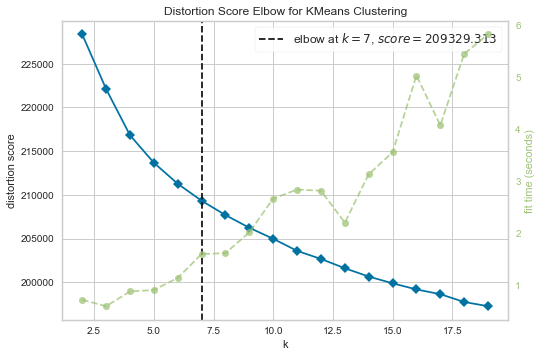

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df)
elbow.show()

In [49]:
elbow.elbow_value_

7

In [50]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df)

In [51]:
clusters_kmeans = kmeans.labels_

In [52]:
df_['cluster'] = clusters_kmeans

In [53]:
df_.groupby('cluster').agg(['count', 'mean', 'median'])

minutes               n_steps              n_ingredients              calories               total fat (PDV)              sugar (PDV)               sodium (PDV)              protein (PDV)              saturated fat (PDV)              carbohydrates (PDV)             
          count   mean median   count  mean median         count  mean median    count   mean median           count  mean median       count   mean median        count  mean median         count  mean median               count  mean median               count  mean median
cluster                                                                                                                                                                                                                                                                           
0          3589 103.19  50.00    3589 11.11  10.00          3589 10.60  10.00     3589 525.90 428.40            3589 43.33  32.00        3589  31.02  17.00         3589 36.71  27.00          3589 64.22  57.00                3589 50.92  34.00                3589 10.44   7.00
1          1919  88.42  50.00    1919 12.03  11.00          1919  9.23   9.00     1919 658.76 311.40            1919 48.68  21.00        1919 203.26  91.00         1919 19.81   8.00          1919 20.09   9.00                1919 69.74  29.00                1919 28.13  13.00
2          3142  61.21  35.00    3142  9.39   8.00          3142  9.51   9.00     3142 319.81 250.80            3142 23.54  16.00        3142  30.87  16.00         3142 23.08  15.00          3142 22.21  14.00                3142 26.40  13.00                3142 11.18   8.00
3          3412  48.99  10.00    3412  5.64   5.00          3412  5.69   5.00     3412 332.67 198.50            3412 24.42   9.00        3412  77.65  25.00         3412 21.94   6.00          3412 17.88   7.00                3412 30.32   9.00                3412 11.60   6.00
4          2222  83.20  30.00    2222  8.69   7.00          2222  8.27   8.00     2222 407.38 279.95            2222 31.36  17.00        2222  67.71  20.00         2222 30.08  14.00          2222 29.19  15.00                2222 39.57  18.00                2222 13.24   8.00
5          2240  98.91  50.00    2240 10.94  10.00          2240 10.86  10.00     2240 530.47 423.65            2240 43.58  31.00        2240  32.28  18.00         2240 37.23  28.00          2240 59.41  52.00                2240 54.27  37.00                2240 11.73   9.00
6          3051  80.51  45.00    3051 11.83  10.00          3051  9.71   9.00     3051 574.28 302.20            3051 41.48  20.00        3051 143.97  55.00         3051 26.58  11.00          3051 24.20  10.00                3051 55.62  26.00                3051 23.23  11.00

In [54]:
df_[df_['cluster'] == 1].ingredients[:10]

4     shortening, icing sugar, vanilla, all-purpose flour, baking powder, sugar, eggs, salt, milk, butter
30                                                                eggs, sugar, flour, milk, butter, fruit
39    unsalted butter, smart balance omega plus, walnuts, cholesterol-free egg substitute, vanilla, ba...
50    graham cracker crumbs, maple syrup, almond extract, silken tofu, sugar, tahini, salt, lemon juic...
72    unsweetened cocoa, all-purpose flour, baking powder, baking soda, egg whites, dark brown sugar, ...
73                         rice vermicelli, sugar, ground cardamom, rose water, olive oil, saffron, water
80    wheat flour, old fashioned oats, granulated sugar, baking powder, baking soda, salt, dried fruit...
86                            flour, sugar, baking powder, cocoa powder, salt, milk, vanilla extract, oil
87                                     butter, sugar, self-rising flour, eggs, milk, pure vanilla extract
97                                            

In [56]:
df_[df_['cluster'] == 2].ingredients[:10]

2          frozen chopped spinach, eggs, garlic powder, soft breadcrumbs, oregano, margarine, sage, onion
15    rice noodles, carrot, english cucumber, green onions, bean sprouts, garlic, fresh ginger, light ...
24    salad greens, green onions, salt, pepper, salad seasoning, carrots, fresh corn kernels, green pe...
25                egg, plain breadcrumbs, cauliflower florets, vegetable oil, salt, pepper, parsley sprig
32    ghee, kidney beans, onion, garlic clove, carrot, potatoes, garam masala, curry powder, tabasco s...
34    butter, carrot, banana, onion, shallot, garlic clove, bay leaf, chicken stock, canned pumpkin, c...
58                                            artichoke, garlic cloves, lemon, olive oil, sea salt, broth
68    mushrooms, garlic, fresh curly-leaf parsley, lemon, juice of, extra virgin olive oil, salt and p...
70                                cauliflower florets, ranch salad dressing, green onion, salt and pepper
75    head of cabbage, onion, fresh mushrooms,

In [62]:
df_[df_['cluster'] == 5].ingredients[:10]

1     ground beef, onion, tomato sauce, taco sauce, salt, pepper, tabasco sauce, hot chili pepper, cor...
3     ground beef, onion, frozen vegetables, cream of mushroom soup, condensed cream of mushroom & gar...
16    chicken, cider vinegar, worcestershire sauce, chili powder, salt, black pepper, hot red pepper s...
22    boneless skinless chicken breasts, garlic cloves, soy yogurt, turmeric, onions, chicken stock, c...
23    rump roast, garlic powder, dried oregano, black pepper, boiling water, beef bouillon cubes, drie...
38                                                             chicken wings, soy sauce, dark brown sugar
48                                            chicken carcasses, salt, bay leaves, potatoes, leek, pepper
54    mostaccioli pasta, butter, flour, salt, pepper, milk, sharp cheddar cheese, parmesan cheese, swi...
65    yeast, oats, oat flour, rice flour, cornstarch, tapioca flour, sorghum flour, xanthan gum, salt,...
66    vegan chicken, soy yogurt, fresh lemon j

## Conclusion

- We see that segment 1 belongs to the set of those that contain less protein and more sugar. Ingredients of the first 10 observations belonging to this cluster also say that these nutrients may be dessert or bakery products.

- In segment 2, there are foods with low values in terms of fat, carbohydrates, and calories contained in them. When we look at the ingredients, it seems that vegetable-based foods are included.

- Easy-to-prepare  foods containing fewer ingredients are included in segment 3.

- The 5th segment consists mainly of foods containing animal-based products